# RV - Data Science Technical

**Kyle Shepherd - 12.19.24**

In [46]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# I found that SDG worked more consistently than Adam, this is common as Adam tries to converge faster and more efficiently
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns


In [47]:
# Load data
data = pd.read_csv('train.csv')
# Inspect the dataset
print(data.info())       # Summary of columns and data types
print(data.describe())   # Statistics for numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   100000 non-null  object 
 1   userId                 100000 non-null  object 
 2   sessionReferrer        100000 non-null  object 
 3   browser                100000 non-null  object 
 4   deviceType             100000 non-null  object 
 5   estimatedAnnualIncome  79986 non-null   float64
 6   estimatedPropertyType  100000 non-null  object 
 7   visitCount             100000 non-null  int64  
 8   pageURL                100000 non-null  object 
 9   ctaCopy                100000 non-null  object 
 10  ctaPlacement           100000 non-null  object 
 11  editorialSnippet       100000 non-null  object 
 12  scrollDepth            100000 non-null  int64  
 13  clickedCTA             100000 non-null  int64  
 14  submittedForm          100000 non-nul

In [48]:
# Create an SQLite connection
conn = sqlite3.connect(':memory:')  # In-memory database

# Save DataFrame to SQL table
data.to_sql('mortgage_data', conn, if_exists='replace', index=False)

print("Data loaded into database.")

Data loaded into database.


In [49]:
pd.set_option('display.max_colwidth', None)
query = "SELECT DISTINCT pageUrl FROM mortgage_data limit 1;"  # Change this query as needed to find distinct variables
result = pd.read_sql_query(query, conn)

print(result)

                                                          pageURL
0  https://www.financialservices.com/mortgages/types-of-mortgages


*Here are some statistics from my data preparation phase*

---

## **Data Summary**

### **Distinct Categories**

- **sessionReferrer**  
Google Social Direct Email

- **browser**  
Safari Chrome Firefox Edge

- **deviceType**  
Mobile Desktop

- **estimatedPropertyType**  
Apartment House Townhome Mobile Home

- **ctaCopy** 
  1. First Time? We've Made it Easy to Find the Best Options  
  2. Access Your Personalized Mortgage Rates Now  
  3. Get Pre-Approved for a Mortgage in 5 Minutes  

- **pageURL**  
  Example URLs:  
  1. [https://www.financialservices.com/mortgages/types-of-mortgages](https://www.financialservices.com/mortgages/types-of-mortgages)  
  2. [https://www.financialservices.com/mortgages/how-to-get-the-best-mortgage-rate](https://www.financialservices.com/mortgages/how-to-get-the-best-mortgage-rate)  
  3. [https://www.financialservices.com/mortgages/first-time-homebuyer-guide](https://www.financialservices.com/mortgages/first-time-homebuyer-guide)  
  4. [https://www.financialservices.com/mortgages/refinance-rates](https://www.financialservices.com/mortgages/refinance-rates)  
  5. [https://www.financialservices.com/mortgages/reviews](https://www.financialservices.com/mortgages/reviews)  
  6. [https://www.financialservices.com/mortgages/what-is-mortgage](https://www.financialservices.com/mortgages/what-is-mortgage)  
  7. [https://www.financialservices.com/mortgages/apply](https://www.financialservices.com/mortgages/apply)  
  8. [https://www.financialservices.com/mortgages/mortgage-calculator](https://www.financialservices.com/mortgages/mortgage-calculator)  
  9. [https://www.financialservices.com/mortgages/best-mortgage-lenders](https://www.financialservices.com/mortgages/best-mortgage-lenders)  
  10. [https://www.financialservices.com/mortgages/30-year-mortgage-rates](https://www.financialservices.com/mortgages/30-year-mortgage-rates)

- **ctaPlacement**  
Middle, Bottom, Top

- **editorialSnippet**  
  Example Snippets:  
  1. Understand the pros and cons of fixed-rate, adjustable-rate mortgages.  
  2. Equip yourself with knowledge. Understand the mortgage basics.  
  3. Navigate the home buying journey with confidence.  
  4. Our tools help you assess whether refinancing is right for you.  
  5. Navigate the complexities of mortgage rates with ease.  
  6. Build a solid foundation of knowledge about mortgages.  
  7. Embark on your homeownership journey with our resources.  
  8. New to mortgages? Learn the basics of how they work.  
  9. Make an informed choice. Our detailed overview is here to help.  
  10. Our team of experienced professionals is dedicated to guiding you.  
  11. Explore how different interest rates and loan types affect payments.  
  12. From improving your credit score to timing your loan application, we help.  
  13. Discover the top mortgage lenders of the year.  
  14. Compare rates, customer service, and loan options side by side.  
  15. Take control of your mortgage journey with our expert advice.  
  16. Our comprehensive reviews offer insights into mortgage lenders.  
  17. Understand how market fluctuations impact long-term rates.  
  18. We break down mortgage terminology and concepts for you.  
  19. Discover what sets top mortgage lenders apart from the rest.  
  20. Your choice of lender matters. Use our insights to make the right call.  
  21. Unlock new financial opportunities by refinancing your mortgage.  
  22. Stay updated with the latest 30-year mortgage rates.  
  23. Embarking on your first home purchase? Our comprehensive guide is here.  
  24. Compare current 30-year mortgage rates from top lenders.  
  25. Learn strategies to secure the best mortgage rate possible.  
  26. Considering refinancing your mortgage? Explore your options.  
  27. From budgeting to closing, we provide insights at every step.  
  28. Explore the different types of mortgages available to you.  
  29. Our mortgage calculator is a powerful tool for planning.  
  30. Take the first step towards securing your dream home.  
  
### **Data Columns and Types**
| Column                  | Non-Null Count | Type      |
|-------------------------|----------------|-----------|
| date                    | 100,000        | object    |
| userId                  | 100,000        | object    |
| sessionReferrer         | 100,000        | object    |
| browser                 | 100,000        | object    |
| deviceType              | 100,000        | object    |
| estimatedAnnualIncome   | 79,986         | float64   |
| estimatedPropertyType   | 100,000        | object    |
| visitCount              | 100,000        | int64     |
| pageURL                 | 100,000        | object    |
| ctaCopy                 | 100,000        | object    |
| ctaPlacement            | 100,000        | object    |
| editorialSnippet        | 100,000        | object    |
| scrollDepth             | 100,000        | int64     |
| clickedCTA              | 100,000        | int64     |
| submittedataorm           | 100,000        | int64     |
| scheduledAppointment    | 100,000        | int64     |
| mortgageVariation       | 5,517          | object    |
| revenue                 | 5,517          | float64   |

---

### **Descriptive Statistics**

#### **Numerical Columns**
| Metric                   | estimatedAnnualIncome | visitCount | scrollDepth | clickedCTA | submittedataorm | scheduledAppointment | revenue   |
|--------------------------|------------------------|------------|-------------|------------|---------------|-----------------------|-----------|
| Count                   | 79,986                | 100,000    | 100,000     | 100,000    | 100,000       | 100,000               | 5,517     |
| Mean                    | 130,567.14            | 2.23       | 62.26       | 0.17       | 0.15          | 0.06                  | 218.06    |
| Std. Dev.               | 62,439.13             | 2.07       | 30.14       | 0.38       | 0.35          | 0.23                  | 61.94     |
| Min                     | 50,000.00             | 1.00       | 0.00        | 0.00       | 0.00          | 0.00                  | 165.00    |
| 25th Percentile (Q1)    | 90,000.00             | 1.00       | 50.00       | 0.00       | 0.00          | 0.00                  | 165.00    |
| Median (Q2)             | 116,000.00            | 1.00       | 75.00       | 0.00       | 0.00          | 0.00                  | 225.00    |
| 75th Percentile (Q3)    | 145,000.00            | 3.00       | 75.00       | 0.00       | 0.00          | 0.00                  | 275.00    |
| Max                     | 400,000.00            | 10.00      | 100.00      | 1.00       | 1.00          | 1.00                  | 375.00    |

---

In [50]:
# Load the data
file_path = "train.csv" 
data = pd.read_csv(file_path)

# Find target data, and fill in any Incomes that are not listed with -1 to represent missing data
y = data["clickedCTA"]
data['estimatedAnnualIncome'] = data['estimatedAnnualIncome'].fillna(-1)

# One-hot encode the specified columns
columns_to_one_hot = ["browser", "sessionReferrer", "ctaCopy" , "estimatedPropertyType"]
data = pd.get_dummies(data, columns=columns_to_one_hot, prefix_sep="_")

# Label encode the specified columns
columns_to_label_encode = ["deviceType", "ctaPlacement"]
label_encoders = {}

for column in columns_to_label_encode:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data = data.map(lambda x: 1 if x is True else (0 if x is False else x))

# Drop unnecessary columns and the target variable
columns_to_drop = ["date", "userId", "pageURL", "editorialSnippet", "mortgageVariation", "clickedCTA", "revenue", "scheduledAppointment", "scrollDepth"]
X = data.drop(columns=columns_to_drop)

# Save processed features and target variable to separate files for inspection and training
X_output_path = "processed_X.csv"
y_output_path = "processed_y.csv"
X.to_csv(X_output_path, index=False)
y.to_csv(y_output_path, index=False)

print(f"Processed features saved to {X_output_path}")
print(f"Processed target variable saved to {y_output_path}")

Processed features saved to processed_X.csv
Processed target variable saved to processed_y.csv


**Loading the data below into 2 processed files. Below are the corresponding inputs that have been created for each column (20 input nodes)**

*Values Included*

 - estimatedAnnualIncome
 - visitCount
 - submittedForm

*Label Encodings*

deviceType:

0. Mobile
1. Desktop

ctaPlacement:

0. Bottom
1. Middle
2. Top

*One-hot Encoding*

sessionReferrer:

1. Direct
2. Email
3. Google
4. Social

browser:

1. Chrome
2. Edge
3. Firefox
4. Safari

estimatedPropertyType:

1. Apartment
2. House
3. Mobile Home
4. Townhome

ctaCopy:

1. Access Your Personalized Mortgage Rates Now
2. First Time? We've Made it Easy to Find the Best Mortgage Rate
3. Get Pre-Approved for a Mortgage in 5 Minutes


In [51]:
# Train-test split
X = pd.read_csv("processed_X.csv")
y= pd.read_csv("processed_y.csv")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (important because of the Income variable)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Model Definition
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for probability
])

/Users/kyleshepherd/Downloads/RV - Data Science Technical/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
model.compile(optimizer=SGD(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 588us/step - loss: 0.5979 - val_loss: 0.4076
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - loss: 0.4135 - val_loss: 0.2822
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - loss: 0.3130 - val_loss: 0.1676
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - loss: 0.2171 - val_loss: 0.1216
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - loss: 0.1787 - val_loss: 0.1116
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - loss: 0.1610 - val_loss: 0.1084
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 611us/step - loss: 0.1509 - val_loss: 0.1073
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 0.1467 - val_loss: 0.1063
Epoch 9/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.1384 - val_loss: 0.1052
Epoch 10/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 0.1374 - val_loss: 0.1050
Epoch 11/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - loss: 0.1321 - val_loss: 0.1045
Epoch 12

In [53]:
# Make predictions
y_val_pred = model.predict(X_val)
y_pred = (y_val_pred > 0.5).astype(int)  # Threshold set at 0.5

# Calculate log loss, precission, and recall
log_loss_value = log_loss(y_val, y_val_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
print(f'Validation Log Loss: {log_loss_value}')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
Validation Log Loss: 0.10285462077021613
Precision: 1.0
Recall: 0.8623435722411832
F1 Score: 0.9260843005497862


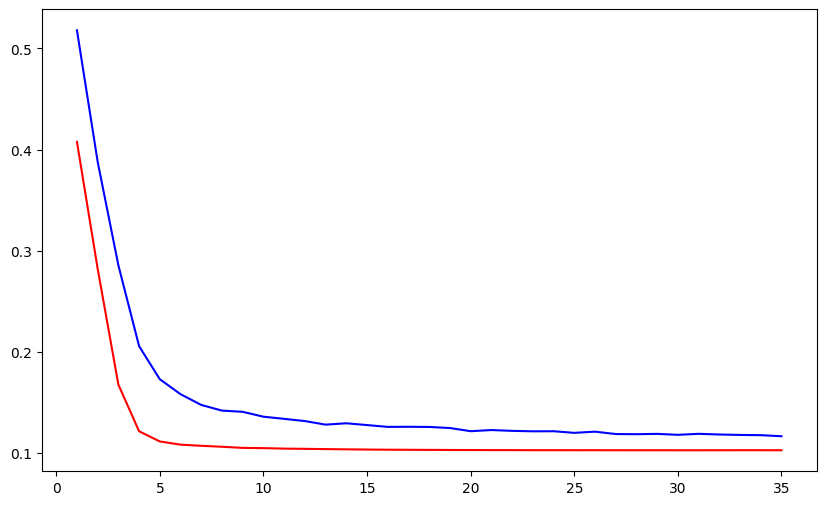

In [54]:
# Loss graph to show convergence (Blue = Train, Red = Validation)
# If loss graph looks weird, run the model again, it may have started in the minimum
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='red')

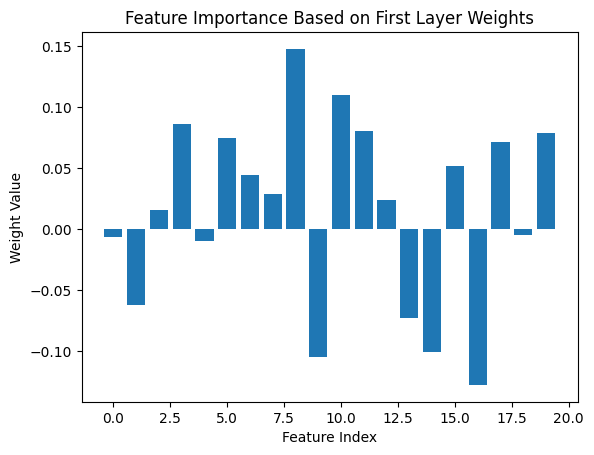

In [55]:
# Feature Importance 
weights, biases = model.layers[0].get_weights()

# Visualize the weights (importance of features in the first dense layer)
plt.bar(range(weights.shape[0]), weights[:, 0])  # weights for the first neuron
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Importance Based on First Layer Weights')
plt.show()

**Feature Key**
0. deviceType
1. estimatedAnnualIncome
2. visitCount
3. ctaPlacement
4. submittedForm
5. browser_Chrome
6. browser_Edge
7. browser_Firefox
8. browser_Safari
9. sessionReferrer_Direct
10. sessionReferrer_Email
11. sessionReferrer_Google
12. sessionReferrer_Social
13. ctaCopy_Access Your Personalized Mortgage Rates Now
14. ctaCopy_First Time? We've Made it Easy to Find the Best Mortgage Rate
15. ctaCopy_Get Pre-Approved for a Mortgage in 5 Minutes 
16. estimatedPropertyType_Apartment
17. estimatedPropertyType_House
18. estimatedPropertyType_Mobile Home
19. estimatedPropertyType_Townhome

In [56]:
# Load the test data (test.csv)
test_data = pd.read_csv('test.csv')
# Saving backup file to access user_id later
data = test_data

# Using the same code as before with a couple changes to get the same kind of input vector 
data['estimatedAnnualIncome'] = data['estimatedAnnualIncome'].fillna(-1)

# One-hot encode the specified columns
columns_to_one_hot = ["browser", "sessionReferrer", "ctaCopy" , "estimatedPropertyType"]
data = pd.get_dummies(data, columns=columns_to_one_hot, prefix_sep="_")

# Label encode the specified columns
columns_to_label_encode = ["deviceType", "ctaPlacement"]
label_encoders = {}

for column in columns_to_label_encode:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data = data.map(lambda x: 1 if x is True else (0 if x is False else x))

# Drop unnecessary columns not used in the model
columns_to_drop = ["date", "userId", "pageURL", "editorialSnippet", "mortgageVariation", "revenue", "scheduledAppointment", "scrollDepth"]
data = data.drop(columns=columns_to_drop)

# Preprocess the test data (apply the same scaling as on the training model)
scaler = StandardScaler()
X_test = scaler.fit_transform(data) 

# Make predictions (probabilities) using model
predictions = model.predict(X_test).ravel()

# Create a DataFrame with userId and predicted probabilities
submission_df = pd.DataFrame({
    'userId': test_data['userId'],
    'pr_CTA': predictions
})

# Function given to save predictions in the correct format
def make_submission(name, data_frame):
    """
    Parameters:
    -----------
        name:               string, your name
        data_frame:         pandas DataFrame [20000, 2], userId and 
                            predicted probabilities on the test set
    """
    cnames = data_frame.columns.values
    if not isinstance(data_frame, pd.DataFrame):
        raise ValueError('Expecting a pandas DataFrame for argument 2')
    elif cnames[0] != 'userId':
        raise ValueError('Column name 0 incorrect, expecting userId, received ' + cnames[0])
        
    t0 = time()
    filename = name + '_predictions.csv'
    data_frame.to_csv(filename, index=False)
    return '{fname} written in {t:.{rd}f} ms'.format(fname=filename, t=(time() - t0) / 1000., rd=3)

# Call the function to save the predictions
make_submission('Kyle_Shepherd', submission_df)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


'Kyle_Shepherd_predictions.csv written in 0.000 ms'

In [57]:
# Printing the head of the predictions
pred = pd.read_csv("Kyle_Shepherd_predictions.csv")
print(pred.head())

        userId    pr_CTA
0  user_175722  0.036991
1  user_180185  0.016257
2  user_119865  0.028216
3  user_176700  0.042127
4  user_192992  0.060454


/var/folders/n9/gwddnbxx7hn9wp_79gsplz_00000gn/T/ipykernel_64684/587381271.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_performance = validation_df.groupby(['IncomeGroup', 'estimatedPropertyType'])['y_pred_prob'].mean()
/var/folders/n9/gwddnbxx7hn9wp_79gsplz_00000gn/T/ipykernel_64684/587381271.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = group_performance_df.pivot_table(


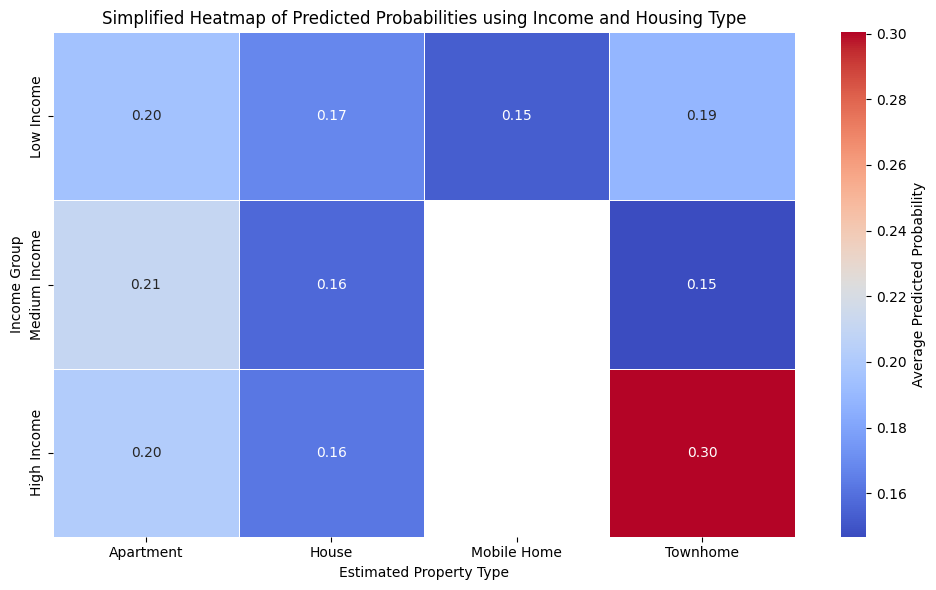

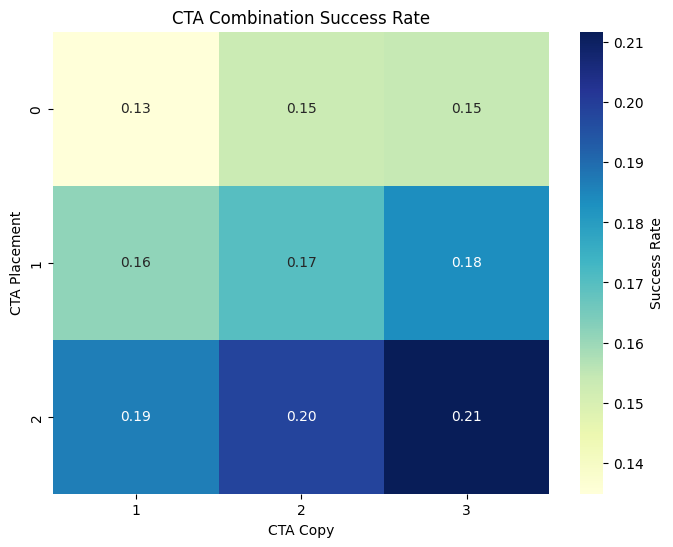

Overall success rate: 0.17
The champion CTA combination is 2 placement with 3 copy.
The success rate for this champion combination is 0.21.
The champion combination is more successful than the overall average.


In [58]:
# Step 1: Prepare validation DataFrame with predicted probabilities
X_val_df = pd.DataFrame(X_val, columns=X.columns)  # Validation features
y_val_df = pd.DataFrame(y_val, columns=['y_true'])  # Target variable
y_val_pred_df = pd.DataFrame(y_val_pred, columns=['y_pred_prob'])  # Predicted probabilities

# Combine validation features, target, and predictions into one DataFrame
validation_df = pd.concat([X_val_df.reset_index(drop=True), y_val_df.reset_index(drop=True), y_val_pred_df.reset_index(drop=True)], axis=1)

# Step 2: Extract 'estimatedPropertyType' using one-hot encoded columns
validation_df['estimatedPropertyType'] = validation_df[
    ['estimatedPropertyType_Apartment', 'estimatedPropertyType_House', 
     'estimatedPropertyType_Mobile Home', 'estimatedPropertyType_Townhome']
].idxmax(axis=1).str.replace('estimatedPropertyType_', '')

# Step 3: Create income bins for grouping
validation_df['IncomeGroup'] = pd.cut(
    validation_df['estimatedAnnualIncome'],
    bins=3,  # Divide into three groups: Low, Medium, High
    labels=['Low Income', 'Medium Income', 'High Income']
)

# Step 4: Group performance by income bins and property type
group_performance = validation_df.groupby(['IncomeGroup', 'estimatedPropertyType'])['y_pred_prob'].mean()

# Step 5: Convert group performance to a pivot table
group_performance_df = group_performance.reset_index()
heatmap_data = group_performance_df.pivot_table(
    index='IncomeGroup',
    columns='estimatedPropertyType',
    values='y_pred_prob'
)

# Step 6: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,  # Display values in the heatmap
    fmt=".2f",   # Format values to 2 decimal places
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Average Predicted Probability'}
)
plt.title("Simplified Heatmap of Predicted Probabilities using Income and Housing Type")
plt.xlabel("Estimated Property Type")
plt.ylabel("Income Group")
plt.tight_layout()
plt.show()

# Step 7: Prepare the DataFrame for CTA combinations
cta_columns = [
    "ctaCopy_Access Your Personalized Mortgage Rates Now",
    "ctaCopy_First Time? We've Made it Easy to Find the Best Mortgage Rate",
    "ctaCopy_Get Pre-Approved for a Mortgage in 5 Minutes"
]

# Rename CTA columns
cta_column_map = {
    cta_columns[0]: 'ctaCopy_1',
    cta_columns[1]: 'ctaCopy_2',
    cta_columns[2]: 'ctaCopy_3'
}
X_df = X.rename(columns=cta_column_map)

# Combine feature set (X) and target variable (y)
df = pd.concat([X_df, y], axis=1)

# Step 8: Determine the most used CTA for each row
df['ctaCopy'] = df[['ctaCopy_1', 'ctaCopy_2', 'ctaCopy_3']].idxmax(axis=1).str.replace('ctaCopy_', '')

# Step 9: Calculate success rate for each CTA combination
cta_combinations = df.groupby(['ctaPlacement', 'ctaCopy'])['clickedCTA'].mean().reset_index()

# Step 10: Reshape the data into a pivot table for visualization
heatmap_data = cta_combinations.pivot(index='ctaPlacement', columns='ctaCopy', values='clickedCTA')

# Step 11: Plot the CTA combination success rate heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Success Rate'})
plt.title('CTA Combination Success Rate')
plt.xlabel('CTA Copy')
plt.ylabel('CTA Placement')
plt.show()

# Step 12: Calculate the overall success rate for comparison
overall_success_rate = df['clickedCTA'].mean()
print(f'Overall success rate: {overall_success_rate:.2f}')

# Step 13: Identify the champion CTA combination (highest success rate)
champion_combination = cta_combinations.loc[cta_combinations['clickedCTA'].idxmax()]
champion_placement = champion_combination['ctaPlacement']
champion_copy = champion_combination['ctaCopy']
champion_success_rate = champion_combination['clickedCTA']

# Print champion combination and success rate
print(f"The champion CTA combination is {champion_placement} placement with {champion_copy} copy.")
print(f"The success rate for this champion combination is {champion_success_rate:.2f}.")

# Step 14: Compare the champion success rate with the overall success rate
if champion_success_rate > overall_success_rate:
    print("The champion combination is more successful than the overall average.")
else:
    print("The champion combination is not more successful than the overall average.")

## Questions

1. What relevant key metrics are provided to evaluate the CTA combinations? And which
CTA Copy and CTA Placement did best/worst based on the key metrics?

I am using metrics such as Log Loss, Precision, Recall, and F1 Score to evaluate the different CTA Combinations. Precision and Recall specifically are used to help measure the amount of succesful CTA Interactions. Using the feature importance extractor, we can see that there is a negative correlation between the CTA Copy "First Time? We've Made it Easy to Find the Best Mortgage Rate", but a possitive correlation between the CTA Copy "Access Your Personalized Mortgage Rates Now", and an even higher correlation between the CTA Copy "Get Pre-Approved for a Mortgage in 5 Minutes". The CTA Placement was known for not having much impact on the Clicked CTA throughout all of my testing.

2. Which groups of people tend to be more correlated or less correlated with our key
metrics?

We can see from the plot above, that there is not many strong correlations between the estimated property type, estimated income and the prediction. There are a couple of categories that stand out with high income people living in a townhome, they are more likely to have clicked the CTA than those who are low-income in a mobile home or medium income in a townhouse.

3. What ways can you manipulate the columns/dataset to create features that increase
predictive power towards our key metric?

There are a couple of ways that you can manipulate the data. One way that I did not do, but could have been beneficial would be to group similar columns such as browser and deviceType to find even more patterns in the way that devices and browsers interact. One way that I ensured that the columns were understood by the neural network was to create one-hot encodings to allow the model to differentiate between categories. I applied normalization or scaling to numerical features to ensure that all features contribute equally to the model and to improve convergence for algorithms sensitive to scale, and I created flags that would alert the model to missing data, specifically for the annual income column. All of these things can come together to ensure the model better understands the problem at hand and is able to give the best output.

4. Besides Log Loss, what other metrics will you use to evaluate the model's performance,
and why?

In addition to Log Loss, I also used Precision, Recall, and F1 Score to evaluate the model's performance. These metrics provide a more comprehensive view of how well the model performs, especially in imbalanced datasets like mine.
Precision helps identify how many of the predicted positives are actually correct. It’s particularly useful in detecting false positives and understanding when to trust the model's positive predictions. In my case, the precision was close to 1, which indicates that when the model predicts a click, it’s almost always correct.
Recall measures how effectively the model identifies actual positive instances (clicks). While the recall was closer to 0.85, it shows that the model misses some instances where it should have predicted a click. This imbalance between precision and recall indicates that while the model is good at predicting clicks when it does so, it’s not capturing all of the actual clicks.
F1 Score was used to balance the trade-off between precision and recall, especially since the dataset is imbalanced (with more non-clicks than clicks). The F1 score, which is the harmonic mean of precision and recall, provides a more balanced measure. Since the precision was high but recall was a bit lower, the F1 score (around 0.92) reflects this trade-off and gives a more realistic assessment of the model's overall performance.

5. What additional predictive model would you build to inform which CTA combinations
would maximize the revenue in addition to predict ClickedCTA, and why?

If maximizing revenue was the goal in this scenario, you would want to utilize a classification model to classify which customers bought a morgage and which one A-D, and wheere to center your efforts to maximize the number of D type morgage customers you bring in, instead of focusing on the ClickedCTA. This is a different problem though, as there are many more steps to buying the morgage than the ClickedCTA variable, so there would most likely need to be another data collection phase to this process.

6. If we called one of these CTA combinations our champion (serve it 100% of the time),
how much incrementally is that worth to us vs. the average of the rest of the split test?

If we were to use the champion CTA combination ("Get Pre-Approved for a Mortgage in 5 Minutes" at the top of the screen) 100% of the time, we could expect an incremental improvement compared to the average of the other split test combinations.
From my calculations, the champion combination achieves a 21% success rate, whereas the overall success rate is 17%. This indicates that by serving the champion CTA combination consistently across the website, we would see a 4% increase in click success rate. This improvement highlights the value of prioritizing the CTA combination that resonates most with the target audience, simplifying the user experience and maximizing conversion potential.